
## Voice User Interfaces: Speech Recognition with Neural Networks


## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, we will engage in our investigations, to design our own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, we will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set. The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  We can also play the audio in the notebook!

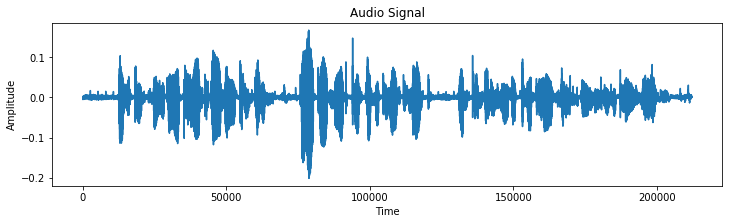

**Shape of Audio Signal** : (212121,)

**Transcript** : instantly they absorbed all my attention though i dared not give them a direct look and continued to observe them only in the glass

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, we won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Our acoustic model will accept the feature representation as input.

In this project, we will explore two possible feature representations. We can read more about deep learning architectures that can accept raw audio input, from here [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, we will **not** dig deeply into the details of how a spectrogram is calculated; but, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in our repository.

The code that we have returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (We can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

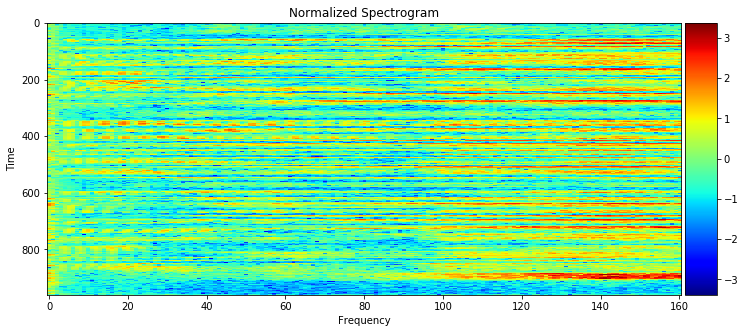

**Shape of Spectrogram** : (961, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). We do **not** dig deeply into the details of how MFCCs are calculated, but for more information, we can see the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

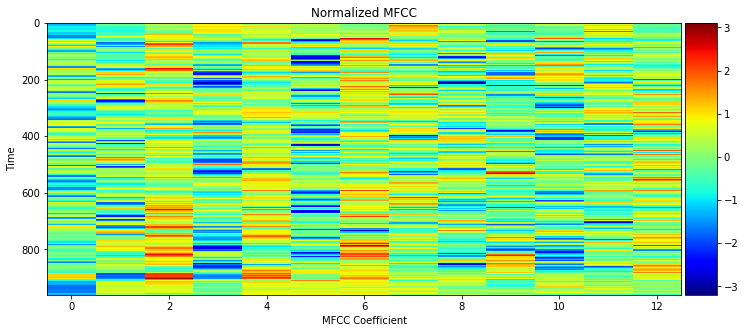

**Shape of MFCC** : (961, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When we construct our pipeline, we will be able to choose to use either spectrogram or MFCC features.  We can refer to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, we will experiment with various neural network architectures for acoustic modeling.  

We will begin by training five relatively simple architectures.  We will write code to implement **Models 1**, **2**, **3**, and **4**.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, we will train our architectures in the notebook.

After experimenting with the five simple architectures, we will have the opportunity to compare their performance.  Based on your findings, we will construct a deeper architecture that is designed to outperform all of the shallow models.

For our convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say we decide to take a break from the notebook after training **Model 1**.  Then, we need not re-execute all prior code cells in the notebook before training **Model 2**.  We need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [5]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

C:\Apps\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model we will use is an RNN.  As shown in the figure below, the RNN will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If we would like to peek under the hood at how characters are mapped to indices in the probability vector, we look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified in Keras.  To import it, we need only run the code cell below.  

In [6]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, we will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If we'd like to peek at the implementation details, we look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train our architecture, we will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.


There are several **optional** arguments that allow us to have more control over the training process.  
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if we choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if we choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  We can experiment with `LSTM` or `SimpleRNN` cellshere.  If we change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, we notice that the loss quickly becomes undefined (`nan`).  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to avoid this issue.

__IMPORTANT NOTE:__ If we notice that our gradient has exploded in any of the models below, we can explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  We can also try restarting the kernel to restart the training process.

In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 89s 837ms/step - loss: 844.6916 - val_loss: 727.4549
Epoch 2/20
106/106 [==============================] - 88s 829ms/step - loss: 752.9534 - val_loss: 726.6260
Epoch 3/20
106/106 [==============================] - 88s 828ms/step - loss: 751.4450 - val_loss: 726.6692
Epoch 4/20
106/106 [==============================] - 88s 835ms/step - loss: 751.2325 - val_loss: 727.5373
Epoch 5/20
106/106 [==============================] - 88s 829ms/step - loss: 752.4904 - val_loss: 725.8152
Epoch 6/20
106/106 [==============================] - 91s 854ms/step - loss: 749.7757 - val_loss: 725.9768
Epoch 7/20
106/106 [==============================] - 89s 836ms/step - loss: 751.4378 - val_loss: 725.4001
Epoch 8/20
106/106 [==============================] - 90s 850ms/step - loss: 750.0811 - val_loss: 725.3277
Epoch 9/20
106/106 [==============================] - 90s 852ms/step - loss: 750.3606 - val_loss: 724.8277
Epoch 10/20
106/106 [================

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

We read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For our next architecture, we will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

We use our research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units, but can change to `GRU` to `SimpleRNN` or `LSTM`, if we like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, we will use the output of our RNN as a hidden layer.  We use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output. We ensure that each `Dense` layer has `output_dim` units.

We use the code cell below to load our model into the `model_1` variable.  We use a value for `input_dim` that matches our chosen audio features, and can change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [8]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_gru_rnn (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`. We can tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [9]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 88s 835ms/step - loss: 279.0115 - val_loss: 227.1464
Epoch 2/20
106/106 [==============================] - 96s 901ms/step - loss: 194.4933 - val_loss: 184.5447
Epoch 3/20
106/106 [==============================] - 93s 874ms/step - loss: 169.6436 - val_loss: 164.6194
Epoch 4/20
106/106 [==============================] - 93s 876ms/step - loss: 157.0714 - val_loss: 156.7143
Epoch 5/20
106/106 [==============================] - 91s 859ms/step - loss: 149.0844 - val_loss: 147.0857
Epoch 6/20
106/106 [==============================] - 92s 864ms/step - loss: 142.4851 - val_loss: 147.0018
Epoch 7/20
106/106 [==============================] - 90s 853ms/step - loss: 137.9614 - val_loss: 142.6677
Epoch 8/20
106/106 [==============================] - 94s 887ms/step - loss: 135.0927 - val_loss: 141.3884
Epoch 9/20
106/106 [==============================] - 93s 873ms/step - loss: 132.6999 - val_loss: 139.5739
Epoch 10/20
106/106 [================

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, our code will throw an error.

Before running the code cell below, we must modify the `cnn_rnn_model` function in `sample_models.py`.  We add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [10]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

C:\Apps\Anaconda3\lib\site-packages\keras\layers\recurrent.py:1012: UserWarning: The `implementation` argument in `SimpleRNN` has been deprecated. Please remove it from your layer call.
  warnings.warn('The `implementation` argument '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
bn_simple_rnn (BatchNormaliz (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  Y

In [11]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 28s 260ms/step - loss: 231.9372 - val_loss: 186.2406
Epoch 2/20
106/106 [==============================] - 25s 235ms/step - loss: 166.9807 - val_loss: 156.5699
Epoch 3/20
106/106 [==============================] - 25s 237ms/step - loss: 146.0478 - val_loss: 143.2701
Epoch 4/20
106/106 [==============================] - 25s 232ms/step - loss: 134.8192 - val_loss: 136.3203
Epoch 5/20
106/106 [==============================] - 25s 233ms/step - loss: 127.6979 - val_loss: 133.4755
Epoch 6/20
106/106 [==============================] - 25s 233ms/step - loss: 120.9278 - val_loss: 132.7434
Epoch 7/20
106/106 [==============================] - 25s 235ms/step - loss: 116.3880 - val_loss: 132.5106
Epoch 8/20
106/106 [==============================] - 25s 236ms/step - loss: 111.7766 - val_loss: 130.0468
Epoch 9/20
106/106 [==============================] - 25s 237ms/step - loss: 109.0140 - val_loss: 132.8803
Epoch 10/20
106/106 [================

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

We can change the supplied values of `units` to whatever we think performs best.  We can change the value of `recur_layers`, as long as our final value is greater than 1. (As a quick check that we have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that we specify here is identical to `rnn_model` if `recur_layers=1`.)

In [12]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
gru_2 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  

In [13]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 171s 2s/step - loss: 301.3089 - val_loss: 261.5133
Epoch 2/20
106/106 [==============================] - 172s 2s/step - loss: 230.0398 - val_loss: 216.7349
Epoch 3/20
106/106 [==============================] - 171s 2s/step - loss: 218.0464 - val_loss: 216.1824
Epoch 4/20
106/106 [==============================] - 172s 2s/step - loss: 210.9305 - val_loss: 213.1402
Epoch 5/20
106/106 [==============================] - 172s 2s/step - loss: 198.8583 - val_loss: 183.6504
Epoch 6/20
106/106 [==============================] - 173s 2s/step - loss: 174.7025 - val_loss: 167.6846
Epoch 7/20
106/106 [==============================] - 173s 2s/step - loss: 159.0053 - val_loss: 154.3355
Epoch 8/20
106/106 [==============================] - 172s 2s/step - loss: 150.4700 - val_loss: 147.7640
Epoch 9/20
106/106 [==============================] - 173s 2s/step - loss: 143.8527 - val_loss: 145.4916
Epoch 10/20
106/106 [==============================] - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

We read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For our next architecture, we will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, we complete the `bidirectional_rnn_model` function in `sample_models.py`.  We can use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [14]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  We can tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [15]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 172s 2s/step - loss: 349.4859 - val_loss: 265.0547
Epoch 2/20
106/106 [==============================] - 176s 2s/step - loss: 241.4896 - val_loss: 202.9878
Epoch 3/20
106/106 [==============================] - 175s 2s/step - loss: 206.6463 - val_loss: 192.8998
Epoch 4/20
106/106 [==============================] - 173s 2s/step - loss: 191.7785 - val_loss: 181.1970
Epoch 5/20
106/106 [==============================] - 174s 2s/step - loss: 180.8743 - val_loss: 171.1543
Epoch 6/20
106/106 [==============================] - 172s 2s/step - loss: 170.4592 - val_loss: 166.0957
Epoch 7/20
106/106 [==============================] - 173s 2s/step - loss: 161.9735 - val_loss: 159.2773
Epoch 8/20
106/106 [==============================] - 173s 2s/step - loss: 154.7749 - val_loss: 156.0936
Epoch 9/20
106/106 [==============================] - 173s 2s/step - loss: 148.4144 - val_loss: 150.0743
Epoch 10/20
106/106 [==============================] - 

<a id='compare'></a>
### Compare the Models

We execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

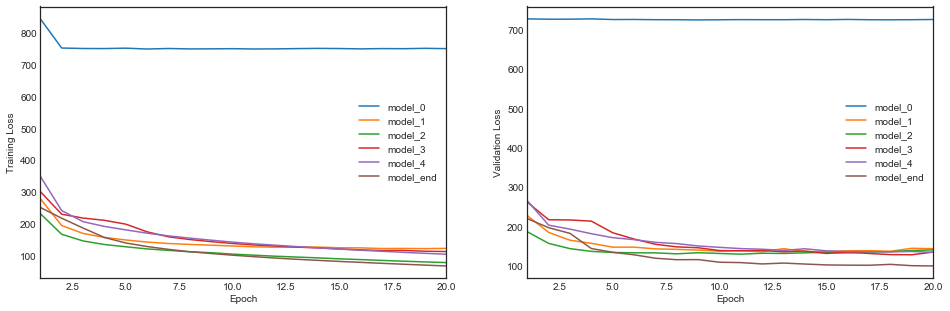

In [33]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Analysis__ We use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  

| Model | Description | Total params | Sec/Epoch | Train loss | Valid loss       
| :- |:-------------:| :-:| :-:| :-:| :-:
|model_0| RNN | 16,617 | 88 | 751.0723 | 725.9049
|model_1| RNN+TimeDist | 223,829 | 91 | 122.6537 | 143.1168
|model_2| CNN+RNN+TimeDist | 442,029 | 25 | 78.0335 | 140.1437
|model_3| Deep RNN+TimeDist | 465,229 | 171 | 112.7274 | 134.5445
|model_4| Bidir RNN+TimeDist | 446,029 | 175 | 104.2471 | 133.9383
|model_end| CNN+Deep Bidir RNN+TimeDist | 1,572,429 | 179 | 67.3783 | 99.2636

__Model 0: RNN__

GRU units instead of SimpleRNN cells are used in model_0 to avoid the exploding gradients problem.

This model has least amount of parameters and thus worst validation loss.

__Model 1: RNN + TimeDistributed Dense__

Adding batch normalization to Model_0 to reduce training time.

Adding time distributed dense layer to find more complex patterns in the training dataset.

Model_1 has similar runtime as Model_0 even though it has more than 10 times of parameters compare to Model_0. 

Model_1 reduces the validation loss a lot, from 726 of Model_0 to 143.

__Model 2: CNN + RNN + TimeDistributed Dense__

Model_2 adds a 1D convolution layer and batch normalization in front of the recurrent layer. 
Another difference compares to Model_1 is using SimpleRNN cells but not GRU units. 

Model_2 has the best runtime in all models. Mainly by introducing CNN layer, and partially due to using SimpleRNN cells.
It has 2x parameters of Model_1, but the runtime is only 28% of Model_1. 

Model_2 also has best training loss of models 0 to 4, however the validation loss is close and only slightly better than Model_1. The validation loss of Model_2 does not change much from epoch 4 to 20, this indicated it has serious overfitting problem.

__Model 3: Deeper RNN + TimeDistributed Dense__

Model_3 uses 2 recurrent layers instead 1 compare to Model_1. 
The validation loss of Model_3 is smaller than Models 0, 1 and 2. 

__Model 4: Bidirectional RNN + TimeDistributed Dense__

Model_4 uses a bidirectional recurrent layer instead of deep recurrent layers in Model_3.

The number of parameters and runtime of Model_4 are similar to Model_3. 

The training and validation losses of Model_4 are also similar and slightly better than Model_3.

__Model End: CNN + Deeper Bidirectional RNN + TimeDistributed Dense__

Model_end combines the advantage of all the models above. 

Model_end has best traing and validation losses. It has similar runtime as Model_3 and Model_4, with close to 4x of parameters.


<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that we've tried out many sample models, we use what we've learned to draft our own architecture!  While our final acoustic model should not be identical to any of the architectures explored above, we can merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, for some more ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If we notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If we choose to include a convolutional layer in our model, we may get better results by working with **dilated convolutions**.  If we choose to use dilated convolutions, we make sure that we are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  We read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  We can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If our model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, we have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that we specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  This line of code is present within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

We will have to add the `output_length` attribute to our final model before running the code cell below.  We can use the `cnn_output_length` function, if it suits our model. 

In [29]:
# specify the model
model_end = final_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_15 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 400)         1600      
__________

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  We can tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [30]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
106/106 [==============================] - 179s 2s/step - loss: 251.2988 - val_loss: 219.5941
Epoch 2/20
106/106 [==============================] - 177s 2s/step - loss: 217.5021 - val_loss: 196.5200
Epoch 3/20
106/106 [==============================] - 182s 2s/step - loss: 186.6503 - val_loss: 182.0364
Epoch 4/20
106/106 [==============================] - 179s 2s/step - loss: 156.9260 - val_loss: 143.4630
Epoch 5/20
106/106 [==============================] - 180s 2s/step - loss: 139.6381 - val_loss: 134.0213
Epoch 6/20
106/106 [==============================] - 180s 2s/step - loss: 128.4262 - val_loss: 127.6025
Epoch 7/20
106/106 [==============================] - 178s 2s/step - loss: 119.5384 - val_loss: 118.8535
Epoch 8/20
106/106 [==============================] - 179s 2s/step - loss: 112.1981 - val_loss: 115.1566
Epoch 9/20
106/106 [==============================] - 181s 2s/step - loss: 106.4878 - val_loss: 115.4068
Epoch 10/20
106/106 [==============================] - 

__Final model architecture:__ 

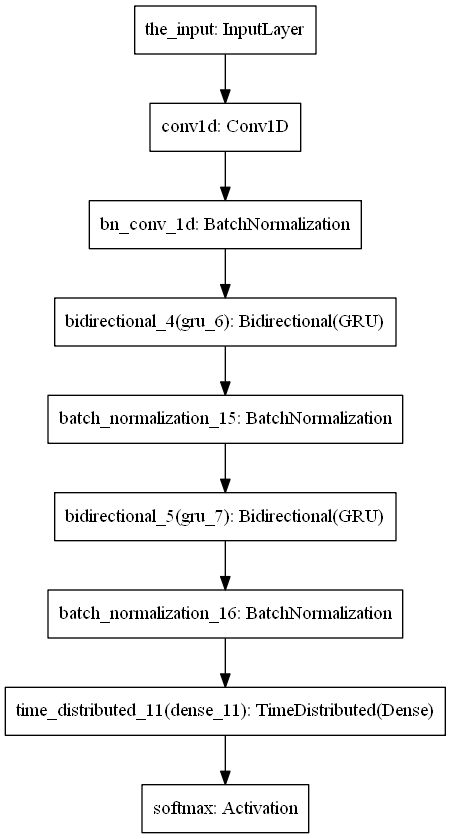

In [34]:
#plot the final model architecture
from keras.utils import plot_model
from IPython.display import Image, display
plot_model(model_end, to_file='model_end.png')
display(Image('model_end.png'))

__Model End: CNN + Deeper Bidirectional RNN + TimeDistributed Dense__

For Model_end, we started with CNN layer and batch normalzation, and both converge the training result quickly and reduce the training time.

For the RNN layers, we use stacked bidirectional RNN layers, followed by Bach normalizatin and Time Distributed Dense layer. We also added dropout=0.2 in the bidirectional RNN layers.

The final model architecture combines the advantage of models 0 to 4. 
Model_end has best traing and validation losses. It has similar runtime as Model_3 and Model_4, with close to 4x of parameters.




<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [23]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

We use the code cell below to obtain the transcription predicted by our final model for the first example in the training dataset.

In [31]:
get_predictions(index=0, 
                partition='train',
                input_to_softmax=final_model(), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 400)         1600      
__________

We use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [32]:
get_predictions(index=0, 
                partition='validation',
                input_to_softmax=final_model(), 
                model_path='results/model_end.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
bidirectional_8 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_19 (Batc (None, None, 400)         1600      
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 400)         1600      
__________

One standard way to improve the results of the decoder is to incorporate a language model but we won't pursue this in the notebook. For creating models that provide improved transcriptions, we can download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!